In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import sys

from apyori import apriori
#testing for git on desktop

In [2]:
def size(df):
    return "{0:.2f} MB".format(sys.getsizeof(df) / (1024 * 1024))

Data Source : https://www.instacart.com/datasets/grocery-shopping-2017

In [3]:
df_opt = pd.read_csv('C:/Users/.../order_products__train.csv')
df_opp = pd.read_csv('C:/Users/.../order_products__prior.csv')
df_orders = pd.read_csv('C:/Users/.../orders.csv')
df_products = pd.read_csv('C:/Users/.../products.csv')

In [4]:
display(df_opt.head())
display(df_opp.head())
display(df_orders.head())
display(df_products.head())

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
#Joining the relevant datasets to get order ids with relevant prodcts
df_orders_product = pd.merge(df_opp, df_products, on='product_id', how='left')

In [6]:
display(df_orders_product.head())
display(df_orders_product.shape)
print(size(df_orders_product))

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


(32434489, 7)

4273.14 MB


In [7]:
#selecting only 2 columns to reduce data size
df_selected = df_orders_product[['order_id', 'product_name']] 
display(df_selected.head())
display(df_selected.shape)
display(size(df_selected))

,order_id,product_name
0,2,Organic Egg Whites
1,2,Michigan Organic Kale
2,2,Garlic Powder
3,2,Coconut Butter
4,2,Natural Sweetener


(32434489, 2)

'3035.86 MB'

In [8]:
#samlping only the first 3 Millions rows of the data to limit the data size
df_subset =  df_selected.iloc[:3000000, :]
print("Dataset Dimensions :", df_subset.shape)
print("Dataset Size :", size(df_subset))

Dataset Dimensions : (3000000, 2)
Dataset Size : 280.82 MB


In [9]:
#EDA to get most common products
common_products = df_subset.groupby(['product_name'])['order_id'].count().reset_index(name='count').sort_values(['count'], ascending=False).reset_index()
cp_t25 = common_products.head(25)
cp_t25

,index,product_name,count
0,3160,Banana,43961
1,2981,Bag of Organic Bananas,35043
2,27759,Organic Strawberries,24418
3,24894,Organic Baby Spinach,22406
4,26246,Organic Hass Avocado,19623
5,24862,Organic Avocado,16163
6,19338,Large Lemon,14198
7,37321,Strawberries,13296
8,20222,Limes,12993
9,28276,Organic Whole Milk,12726


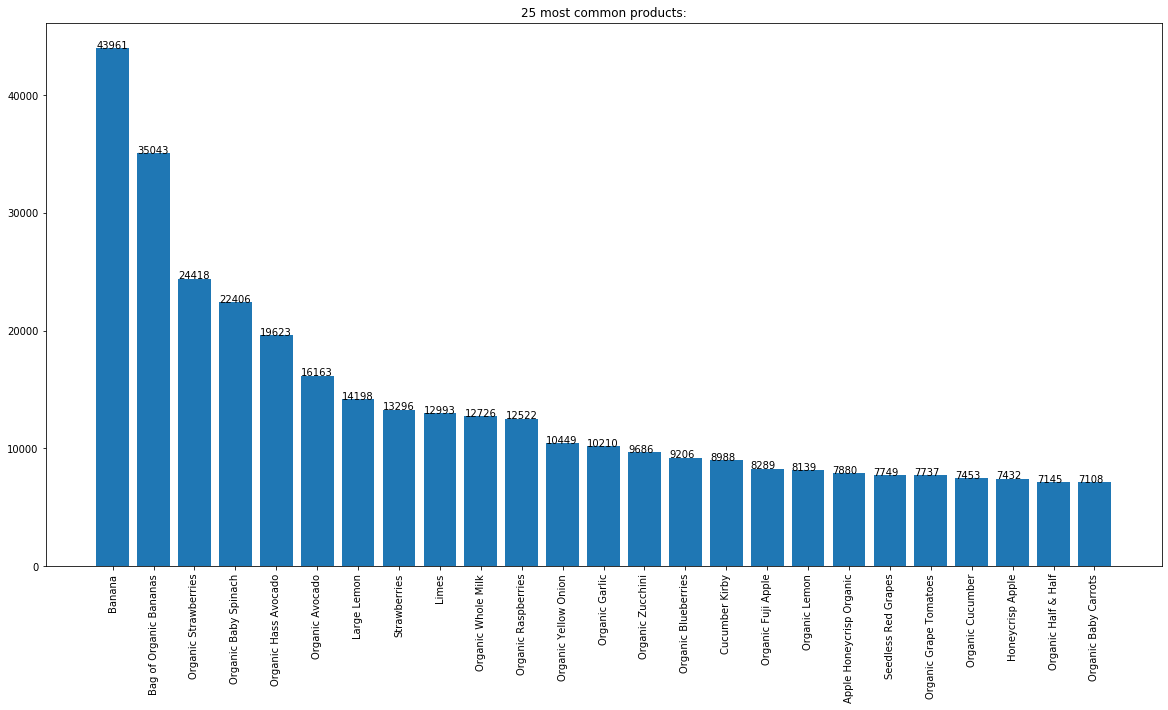

In [10]:
names = list(cp_t25['product_name'])
values = list(cp_t25['count'])
plt.subplots(figsize = (20,10))
bars = plt.bar(range(len((cp_t25['product_name']))),values,tick_label=names)
plt.title('25 most common products:')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .01, yval)
    plt.xticks(rotation=90)
plt.show()

In [11]:
#collapsing all the products in a list associated with their order id. 1-1 mapping to 1-many mapping 
%time df1 = df_subset.groupby(['order_id'])['product_name'].apply(list).reset_index(name='cart_products')
df1 = df1[:-1]
display(df1.head())
display(df1.tail())
display(size(df1))

Wall time: 40.1 s


,order_id,cart_products
0,2,"[Organic Egg Whites, Michigan Organic Kale, Ga..."
1,3,[Total 2% with Strawberry Lowfat Greek Straine...
2,4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr..."
3,5,"[Bag of Organic Bananas, Just Crisp, Parmesan,..."
4,6,"[Cleanse, Dryer Sheets Geranium Scent, Clean D..."


,order_id,cart_products
297447,316711,"[Organic Medjool Dates, Spring Water, Naturall..."
297448,316712,"[Organic Avocado, Original Hummus]"
297449,316714,"[Whole Milk, Organic & Raw Strawberry Serenity..."
297450,316715,"[Orange Chicken, Organic Tomato Cluster, Organ..."
297451,316716,[Organic Whole Wheat Fillo Dough]


'50.77 MB'

Apriori : Method 1

In [12]:
transactions = df1['cart_products']
transactions[0]

['Organic Egg Whites',
 'Michigan Organic Kale',
 'Garlic Powder',
 'Coconut Butter',
 'Natural Sweetener',
 'Carrots',
 'Original Unflavored Gelatine Mix',
 'All Natural No Stir Creamy Almond Butter',
 'Classic Blend Cole Slaw']

In [16]:
%time a_rules = apriori(transactions, min_support=0.01, min_confidance=0.4, min_lift=1.5, max_length=3)

Wall time: 0 ns


In [17]:
list_rules = list(a_rules)
df_rules = pd.DataFrame(list_rules)
display(df_rules.head())
display(df_rules.tail())

,items,support,ordered_statistics
0,"(Organic Baby Spinach, Bag of Organic Bananas)",0.015542,"[((Bag of Organic Bananas), (Organic Baby Spin..."
1,"(Organic Hass Avocado, Bag of Organic Bananas)",0.019230,"[((Bag of Organic Bananas), (Organic Hass Avoc..."
2,"(Organic Raspberries, Bag of Organic Bananas)",0.012291,"[((Bag of Organic Bananas), (Organic Raspberri..."
3,"(Organic Strawberries, Bag of Organic Bananas)",0.019032,"[((Bag of Organic Bananas), (Organic Strawberr..."
4,"(Banana, Cucumber Kirby)",0.010049,"[((Banana), (Cucumber Kirby), 0.06799208389254..."


,items,support,ordered_statistics
8,"(Banana, Strawberries)",0.013118,"[((Banana), (Strawberries), 0.0887604922544983..."
9,"(Organic Hass Avocado, Organic Baby Spinach)",0.010533,"[((Organic Baby Spinach), (Organic Hass Avocad..."
10,"(Organic Strawberries, Organic Baby Spinach)",0.011830,"[((Organic Baby Spinach), (Organic Strawberrie..."
11,"(Organic Hass Avocado, Organic Strawberries)",0.012745,"[((Organic Hass Avocado), (Organic Strawberrie..."
12,"(Organic Strawberries, Organic Raspberries)",0.010281,"[((Organic Raspberries), (Organic Strawberries..."


In [18]:
os_col1 = []
os_col2 = []
os_col3 = []
os_col4 = []

for i in range(df_rules.shape[0]):
    list_flat = df_rules['ordered_statistics'][i][0]
    os_col1.append(list(list_flat[0]))
    os_col2.append(list(list_flat[1]))
    os_col3.append(list_flat[2])
    os_col4.append(list_flat[3])
    
support =list(df_rules['support'])  

In [19]:
df_result = pd.concat([pd.DataFrame(os_col1, columns=['Antecedent']),
                      pd.DataFrame(os_col2, columns=['Consequent']),
                      pd.DataFrame(support, columns=['Support']),
                      pd.DataFrame(os_col3, columns=['Confidence']),
                      pd.DataFrame(os_col4, columns=['Lift'])],
                     axis=1)

df_result

,Antecedent,Consequent,Support,Confidence,Lift
0,Bag of Organic Bananas,Organic Baby Spinach,0.015542,0.131924,1.751359
1,Bag of Organic Bananas,Organic Hass Avocado,0.019230,0.163228,2.474265
2,Bag of Organic Bananas,Organic Raspberries,0.012291,0.104329,2.478267
3,Bag of Organic Bananas,Organic Strawberries,0.019032,0.161544,1.967880
4,Banana,Cucumber Kirby,0.010049,0.067992,2.250154
5,Banana,Large Lemon,0.012721,0.086076,1.803322
6,Banana,Organic Avocado,0.016413,0.111053,2.043738
7,Banana,Organic Fuji Apple,0.010610,0.071791,2.576227
8,Banana,Strawberries,0.013118,0.088760,1.985709
9,Organic Baby Spinach,Organic Hass Avocado,0.010533,0.139829,2.119569


In [20]:
df_result.to_csv('rules_results.csv', index = None)